# Last Millennium Reanalysis with PAGES2k

In this section, we illustrate performing a Last Millennium Reanalysis (LMR) flow assimilating the PAGES2k database with `cfr`.

Required data to complete this tutorial:

- iCESM simulated air surface temperature: [tas_sfc_Amon_iCESM_past1000historical_085001-200512.nc](https://atmos.washington.edu/~rtardif/LMR/prior/tas_sfc_Amon_iCESM_past1000historical_085001-200512.nc)
- iCESM simulated precipitation rate: [pr_sfc_Amon_iCESM_past1000historical_085001-200512.nc](https://atmos.washington.edu/~rtardif/LMR/prior/pr_sfc_Amon_iCESM_past1000historical_085001-200512.nc)
- PAGES2k database: [pages2k_updated_Palmyra_dataset.pkl](./data/pages2k_updated_Palmyra_dataset.pkl)
- [20CR v3](https://psl.noaa.gov/data/gridded/data.20thC_ReanV3.html)
  - Cite: NOAA/CIRES/DOE 20th Century Reanalysis (V3) data provided by the NOAA PSL, Boulder, Colorado, USA, from their website at https://psl.noaa.gov 
  - Paper: https://rmets.onlinelibrary.wiley.com/doi/10.1002/qj.3598
  - tas: [air.2m.mon.mean.nc](https://downloads.psl.noaa.gov/Datasets/20thC_ReanV3/Monthlies/2mSI-MO/air.2m.mon.mean.nc)
  - pr: [prate.mon.mean.nc](https://downloads.psl.noaa.gov/Datasets/20thC_ReanV3/Monthlies/sfcSI-MO/prate.mon.mean.nc)

In [3]:
%load_ext autoreload
%autoreload 2

import cfr
import pandas as pd
import numpy as np

## Load and filter the PAGES2k database

>>> job.configs["slice_proxydb_timespan"] = (1000, 2000)


Slicing ProxyRecord: 100%|██████████| 592/592 [00:03<00:00, 159.86it/s]


>>> job.proxydb updated


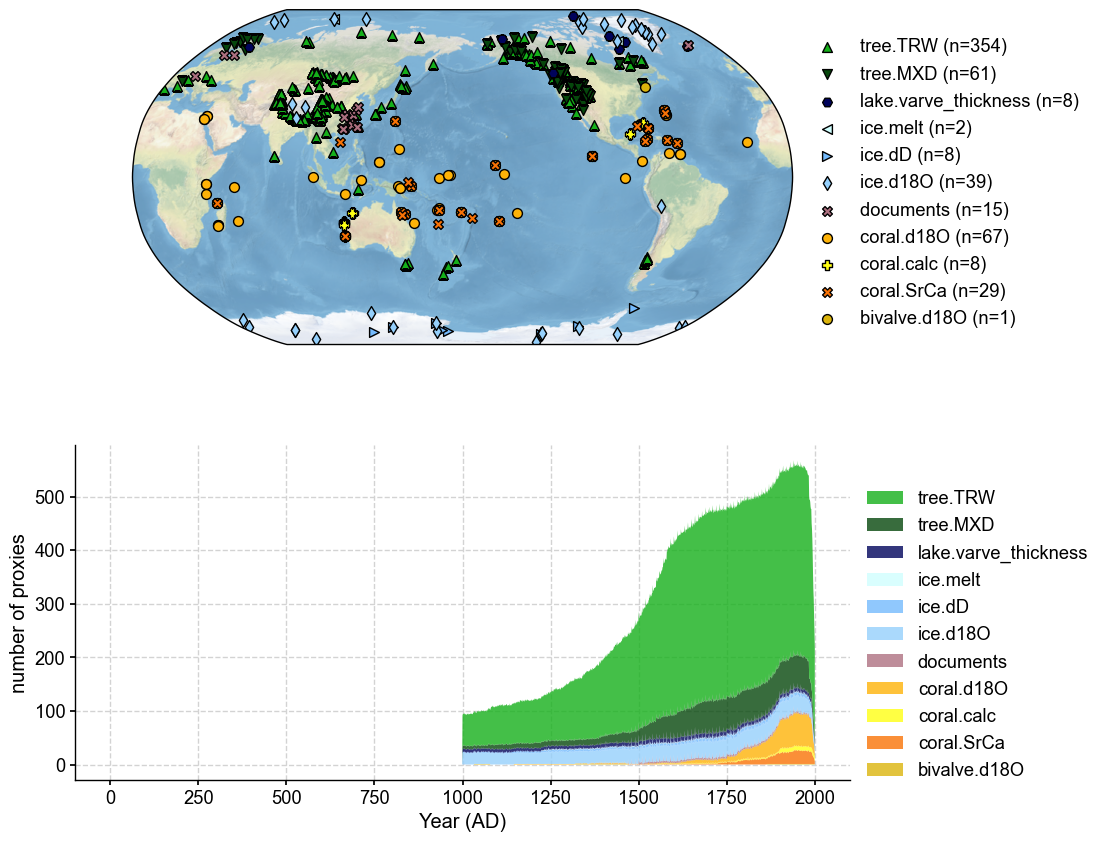

In [2]:
job = cfr.ReconJob()
job.load_proxydb('./data/pages2k_updated_Palmyra_dataset.pkl')
job.filter_proxydb(by='ptype', keys=[
    'coral',
    'ice',
    'bivalve',
    'lake.varve_thickness',
    'tree',
    'documents',
])
job.slice_proxydb(timespan=(1000, 2000), verbose=True)
fig, ax = job.proxydb.plot(plot_count=True)

## Annualize/seasonalize the proxy database

In [3]:
job.annualize_proxydb(verbose=True)

>>> job.configs["annualize_proxydb_months"] = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
>>> job.configs["annualize_proxydb_ptypes"] = {'documents', 'coral.SrCa', 'ice.melt', 'coral.d18O', 'bivalve.d18O', 'tree.TRW', 'tree.MXD', 'lake.varve_thickness', 'coral.calc', 'ice.d18O', 'ice.dD'}


Annualizing ProxyRecord: 100%|██████████| 592/592 [00:57<00:00, 10.30it/s]

>>> 592 records remaining
>>> job.proxydb updated


## Load climate model priors

In [4]:
job.load_clim(
    tag='prior',
    path_dict={
        'tas': './data/tas_sfc_Amon_iCESM_past1000historical_085001-200512.nc',
        'pr': './data/pr_sfc_Amon_iCESM_past1000historical_085001-200512.nc',
    },
    anom_period=(1951, 1980),
    verbose=True,
)

>>> job.configs["prior_path"] = {'tas': './data/tas_sfc_Amon_iCESM_past1000historical_085001-200512.nc', 'pr': './data/pr_sfc_Amon_iCESM_past1000historical_085001-200512.nc'}
>>> job.configs["prior_anom_period"] = (1951, 1980)
>>> job.configs["prior_lon_name"] = lon
>>> job.configs["prior_time_name"] = time
>>> prior variables ['tas', 'pr'] loaded
>>> job.prior created


## Load instrumental observations

In [5]:
job.load_clim(
    tag='obs',
    path_dict={
        'tas': './data/20CRv3/air.2m.mon.mean.nc',
        'pr': './data/20CRv3/prate.mon.mean.nc',
    },
    rename_dict={'tas': 'air', 'pr': 'prate'},
    anom_period=(1951, 1980),
    verbose=True,
)

>>> job.configs["obs_path"] = {'tas': './data/20CRv3/air.2m.mon.mean.nc', 'pr': './data/20CRv3/prate.mon.mean.nc'}
>>> job.configs["obs_rename_dict"] = {'tas': 'air', 'pr': 'prate'}
>>> job.configs["obs_anom_period"] = (1951, 1980)
>>> job.configs["obs_lon_name"] = lon
>>> job.configs["obs_time_name"] = time
>>> obs variables ['tas', 'pr'] loaded
>>> job.obs created


## Calibrate the PSMs

In [6]:
# PSM to be used; 'Linear' by default
ptype_psm_dict = {
    'tree.TRW': 'Bilinear',
}

# Seasonality for each proxy type; calendar annual list(range(1, 13)) by default
growing_seasons = [  # expert curated pool of possible growing seasons for trees
    [1,2,3,4,5,6,7,8,9,10,11,12],
    [6,7,8],
    [3,4,5,6,7,8],
    [6,7,8,9,10,11],
    [-12,1,2],
    [-9,-10,-11,-12,1,2],
    [-12,1,2,3,4,5],
]

ptype_season_dict = {
    'tree.TRW': growing_seasons,
    'tree.MXD': growing_seasons,
}

In [7]:
job.calib_psms(
    ptype_psm_dict=ptype_psm_dict,
    ptype_season_dict=ptype_season_dict,
    verbose=True,
)

>>> job.configs["ptype_psm_dict"] = {'documents': 'Linear', 'coral.SrCa': 'Linear', 'ice.melt': 'Linear', 'coral.d18O': 'Linear', 'bivalve.d18O': 'Linear', 'tree.TRW': 'Bilinear', 'tree.MXD': 'Linear', 'lake.varve_thickness': 'Linear', 'coral.calc': 'Linear', 'ice.d18O': 'Linear', 'ice.dD': 'Linear'}
>>> job.configs["ptype_season_dict"] = {'documents': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 'coral.SrCa': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 'ice.melt': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 'coral.d18O': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 'bivalve.d18O': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 'tree.TRW': [[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], [6, 7, 8], [3, 4, 5, 6, 7, 8], [6, 7, 8, 9, 10, 11], [-12, 1, 2], [-9, -10, -11, -12, 1, 2], [-12, 1, 2, 3, 4, 5]], 'tree.MXD': [[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], [6, 7, 8], [3, 4, 5, 6, 7, 8], [6, 7, 8, 9, 10, 11], [-12, 1, 2], [-9, -10, -11, -12, 1, 2], [-12, 1, 2, 3, 4, 5]], 'lake.varve_thickness': [1, 2, 3, 4, 5, 6, 7

Calibrating the PSMs:   0%|          | 1/592 [00:02<20:19,  2.06s/it]

The number of overlapped data points is 12 < 25. Skipping ...


Calibrating the PSMs:   2%|▏         | 10/592 [00:14<13:36,  1.40s/it]

The number of overlapped data points is 12 < 25. Skipping ...


Calibrating the PSMs:   5%|▍         | 27/592 [00:39<17:03,  1.81s/it]

The number of overlapped data points is 12 < 25. Skipping ...


Calibrating the PSMs:  13%|█▎        | 75/592 [01:47<12:04,  1.40s/it]

The number of overlapped data points is 15 < 25. Skipping ...


Calibrating the PSMs:  15%|█▍        | 86/592 [01:59<10:15,  1.22s/it]

The number of overlapped data points is 23 < 25. Skipping ...


Calibrating the PSMs:  23%|██▎       | 136/592 [03:01<10:41,  1.41s/it]

The number of overlapped data points is 22 < 25. Skipping ...


Calibrating the PSMs:  24%|██▍       | 141/592 [03:09<12:30,  1.66s/it]

The number of overlapped data points is 19 < 25. Skipping ...


Calibrating the PSMs:  28%|██▊       | 164/592 [03:26<05:04,  1.41it/s]

The number of overlapped data points is 12 < 25. Skipping ...


Calibrating the PSMs:  34%|███▍      | 202/592 [04:19<08:17,  1.28s/it]

The number of overlapped data points is 13 < 25. Skipping ...


Calibrating the PSMs:  38%|███▊      | 222/592 [04:41<07:18,  1.19s/it]

The number of overlapped data points is 12 < 25. Skipping ...


Calibrating the PSMs:  41%|████      | 243/592 [05:04<09:23,  1.62s/it]

The number of overlapped data points is 6 < 25. Skipping ...


Calibrating the PSMs:  43%|████▎     | 254/592 [05:17<07:38,  1.36s/it]

The number of overlapped data points is 12 < 25. Skipping ...


Calibrating the PSMs:  49%|████▉     | 290/592 [05:51<03:31,  1.43it/s]

The number of overlapped data points is 0 < 25. Skipping ...


Calibrating the PSMs:  57%|█████▋    | 340/592 [06:57<03:16,  1.28it/s]

The number of overlapped data points is 8 < 25. Skipping ...
The number of overlapped data points is 6 < 25. Skipping ...
The number of overlapped data points is 14 < 25. Skipping ...


Calibrating the PSMs:  59%|█████▉    | 352/592 [07:13<04:46,  1.19s/it]

The number of overlapped data points is 0 < 25. Skipping ...


Calibrating the PSMs:  60%|██████    | 358/592 [07:15<02:25,  1.61it/s]

The number of overlapped data points is 4 < 25. Skipping ...


Calibrating the PSMs:  68%|██████▊   | 402/592 [08:05<03:25,  1.08s/it]

The number of overlapped data points is 12 < 25. Skipping ...


Calibrating the PSMs:  70%|██████▉   | 412/592 [08:21<05:27,  1.82s/it]

The number of overlapped data points is 10 < 25. Skipping ...


Calibrating the PSMs:  78%|███████▊  | 459/592 [09:24<02:02,  1.09it/s]

The number of overlapped data points is 15 < 25. Skipping ...


Calibrating the PSMs:  80%|███████▉  | 472/592 [09:40<03:02,  1.52s/it]

The number of overlapped data points is 3 < 25. Skipping ...


Calibrating the PSMs:  85%|████████▌ | 505/592 [10:33<02:25,  1.67s/it]

The number of overlapped data points is 8 < 25. Skipping ...


Calibrating the PSMs:  96%|█████████▌| 567/592 [11:48<00:21,  1.14it/s]

The number of overlapped data points is 15 < 25. Skipping ...


Calibrating the PSMs: 100%|██████████| 592/592 [12:17<00:00,  1.24s/it]

The number of overlapped data points is 0 < 25. Skipping ...
>>> PSM for Asi_245 failed to be calibrated.
>>> PSM for Asi_242 failed to be calibrated.
>>> PSM for Asi_239 failed to be calibrated.
>>> PSM for Asi_243 failed to be calibrated.
>>> PSM for Ocn_144 failed to be calibrated.
>>> PSM for Ant_022 failed to be calibrated.
>>> PSM for Ocn_145 failed to be calibrated.
>>> PSM for Asi_246 failed to be calibrated.
>>> PSM for Asi_233 failed to be calibrated.
>>> PSM for Asi_237 failed to be calibrated.
>>> PSM for Arc_053 failed to be calibrated.
>>> PSM for Asi_241 failed to be calibrated.
>>> PSM for Ocn_138 failed to be calibrated.
>>> PSM for Ant_013 failed to be calibrated.
>>> PSM for Arc_045 failed to be calibrated.
>>> PSM for Asi_238 failed to be calibrated.
>>> PSM for Ant_016 failed to be calibrated.
>>> PSM for Ant_015 failed to be calibrated.
>>> PSM for Asi_235 failed to be calibrated.
>>> PSM for Asi_236 failed to be calibrated.
>>> PSM for Asi_230 failed to be calibr

(<Figure size 1000x1000 with 1 Axes>, {'map': <GeoAxesSubplot: >})

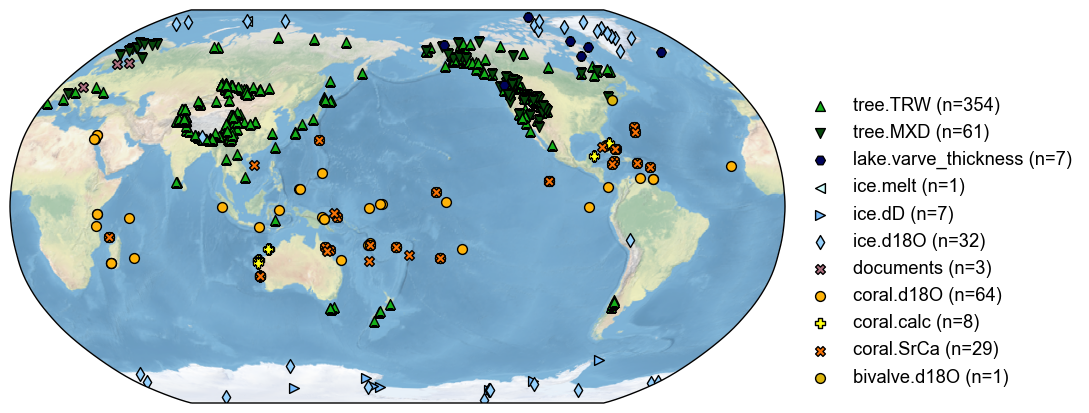

In [29]:
job.proxydb.filter(by='tag', keys=['calibrated']).plot()

## Forward the PSMs

In [8]:
job.forward_psms(verbose=True)

Forwarding the PSMs: 100%|██████████| 567/567 [03:34<00:00,  2.65it/s]

>>> ProxyRecord.pseudo created for 567 records


## Annualize/seasonalize the climate model prior

In [9]:
job.annualize_clim(tag='prior', verbose=True, months=list(range(1, 13)))
# fig, ax = job.prior['tas'].plot(it=-1)

>>> job.configs["prior_annualize_months"] = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
>>> Processing tas ...
>>> Processing pr ...
>>> job.prior updated


## Regrid the prior field

In [10]:
job.regrid_clim(tag='prior', nlat=42, nlon=63, verbose=True)
job.prior['tas'].da

>>> job.configs["prior_regrid_nlat"] = 42
>>> job.configs["prior_regrid_nlon"] = 63
>>> Processing tas ...
>>> Processing pr ...


<xarray.DataArray 'tas' (year: 1156, lat: 42, lon: 63)>
array([[[ 3.50997925e-01,  2.93665610e-01,  3.28684406e-01, ...,
          3.39764206e-01,  3.48886233e-01,  3.50997925e-01],
        [ 9.26483582e-01,  9.18037431e-01,  9.97301386e-01, ...,
          9.85246579e-01,  9.54159491e-01,  9.26483582e-01],
        [ 3.11964038e-01,  5.40504752e-01,  9.30123667e-01, ...,
          1.87633878e-01,  3.17730828e-01,  3.11964038e-01],
        ...,
        [-5.73252682e-01, -4.14780280e-01, -1.83932820e-01, ...,
         -7.05695091e-01, -7.09831750e-01, -5.73252682e-01],
        [-8.44291348e-01, -8.18824882e-01, -7.86828355e-01, ...,
         -7.95048135e-01, -8.31218609e-01, -8.44291348e-01],
        [-1.19067383e+00, -1.19899754e+00, -1.19923323e+00, ...,
         -1.18405519e+00, -1.18602448e+00, -1.19067383e+00]],

       [[ 1.17234550e-01,  6.23495891e-02,  9.40458230e-02, ...,
          1.02707604e-01,  1.14362244e-01,  1.17234550e-01],
        [-1.52815832e-01, -2.10093733e-01, -2.11417284e-01, ...,
          1.84683131e-02, -7.38368771e-02, -1.52815832e-01],
        [-2.08204014e-02, -1.04629322e-01, -1.57633638e-01, ...,
          1.84279648e-01,  2.04299561e-01, -2.08204014e-02],
...
        [-8.86050341e-01, -9.76015805e-01, -9.97395519e-01, ...,
         -5.67774524e-01, -7.35734160e-01, -8.86050341e-01],
        [-5.77959418e-01, -6.22154925e-01, -6.05618197e-01, ...,
         -4.06516483e-01, -4.84799899e-01, -5.77959418e-01],
        [ 2.44318638e-02,  2.62632479e-02,  2.62195634e-02, ...,
          3.35295060e-02,  2.77845733e-02,  2.44318638e-02]],

       [[ 8.57049286e-01,  8.52895183e-01,  8.41191944e-01, ...,
          8.39575983e-01,  8.49399827e-01,  8.57049286e-01],
        [ 2.99372849e-01,  3.34084352e-01,  3.72677423e-01, ...,
          2.92436565e-01,  3.30555435e-01,  2.99372849e-01],
        [-3.54235391e-01, -2.14225590e-01, -7.94867366e-02, ...,
         -2.81496947e-01, -2.75175575e-01, -3.54235391e-01],
        ...,
        [-9.94424978e-01, -9.87675297e-01, -7.83870006e-01, ...,
         -1.87150705e-01, -6.43495374e-01, -9.94424978e-01],
        [ 6.43866220e-01,  5.84103200e-01,  5.61185189e-01, ...,
          8.92312296e-01,  7.54542914e-01,  6.43866220e-01],
        [ 1.69565451e+00,  1.70823039e+00,  1.70603596e+00, ...,
          1.70048966e+00,  1.69468416e+00,  1.69565451e+00]]])
Coordinates:
  * year     (year) int64 850 851 852 853 854 855 ... 2001 2002 2003 2004 2005
  * lon      (lon) float64 0.0 5.806 11.61 17.42 ... 342.6 348.4 354.2 360.0
  * lat      (lat) float64 -90.0 -85.61 -81.22 -76.83 ... 76.83 81.22 85.61 90.0

## (Optional) Save the job object for later reload

In [11]:
job.save('./data/job-lmr-real-pages2k-iCESM', verbose=True)

>>> job.configs["save_dirpath"] = ./data/job-lmr-real-pages2k-iCESM
>>> prior_tas saved to: ./data/job-lmr-real-pages2k-iCESM/prior_tas.nc
>>> prior_pr saved to: ./data/job-lmr-real-pages2k-iCESM/prior_pr.nc
>>> obs_tas saved to: ./data/job-lmr-real-pages2k-iCESM/obs_tas.nc
>>> obs_pr saved to: ./data/job-lmr-real-pages2k-iCESM/obs_pr.nc
>>> job saved to: ./data/job-lmr-real-pages2k-iCESM/job.pkl


In [10]:
job = cfr.ReconJob()
job.load('./data/job-lmr-pages2k-iCESM', verbose=True)

>>> job is loaded
>>> job.prior["pr"].da is loaded
>>> job.prior["tas"].da is loaded
>>> job.obs["pr"].da is loaded
>>> job.obs["tas"].da is loaded


## Data assimilation

In [ ]:
job.prior['pr'].da.values *= 1e5  # to regularize the pr values

job.run_da_mc(
    save_dirpath='./results/lmr-real-pages2k',
    recon_seeds=list(range(1, 3)),  # as an example here; normally set range(1, 21)
    recon_vars=['tas', 'pr'],  # to reconstruct both the tas and pr fields
    recon_period=[1000, 2000],
    verbose=True,
)

## Validation

In [4]:
res = cfr.ReconRes('./results/lmr-pages2k-iCESM', verbose=True)

>>> res.paths:
['./results/lmr-pages2k-iCESM/job_r01_recon.nc', './results/lmr-pages2k-iCESM/job_r02_recon.nc']


In [5]:
res.load(['nino3.4', 'tas', 'pr'], verbose=True)

>>> ReconRes.recons["nino3.4"] created
>>> ReconRes.da["nino3.4"] created
>>> ReconRes.recons["tas"] created
>>> ReconRes.da["tas"] created
>>> ReconRes.recons["pr"] created
>>> ReconRes.da["pr"] created


## Validate the reconstructed NINO3.4


In [11]:
da = job.obs['tas'].annualize().da
da = cfr.utils.geo_mean(da, lat_min=-5, lat_max=5, lon_min=np.mod(-170, 360), lon_max=np.mod(-120, 360))
ref_time = [t for t in da.year]
ref_value = da.values
ref_name = 'truth'

(1000.0, 2000.0)

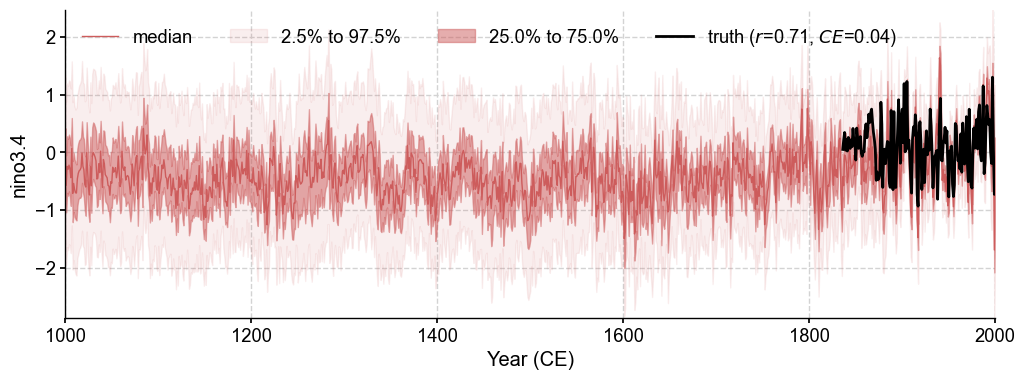

In [12]:
fig, ax = res.recons['nino3.4'].validate(ref_time, ref_value, ref_name).plot_qs()
ax.set_xlim(1000, 2000)

## Validated the reconstructed fields (tas & pr)

In [22]:
# Preparations to add markers representing the sites on the map

lats, lons, colors, markers, markersizes = {}, {}, {}, {}, {}
for pid, pobj in job.proxydb.filter(by='tag', keys=['calibrated']).records.items():
    lats[pid] = pobj.lat
    lons[pid] = pobj.lon
    colors[pid] = cfr.visual.STYLE.colors_dict[pobj.ptype]
    markers[pid] = cfr.visual.STYLE.markers_dict[pobj.ptype]
    markersizes[pid] = 50

/Users/fengzhu/Apps/miniconda3/envs/cfr-env/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1700: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  result = super().scatter(*args, **kwargs)


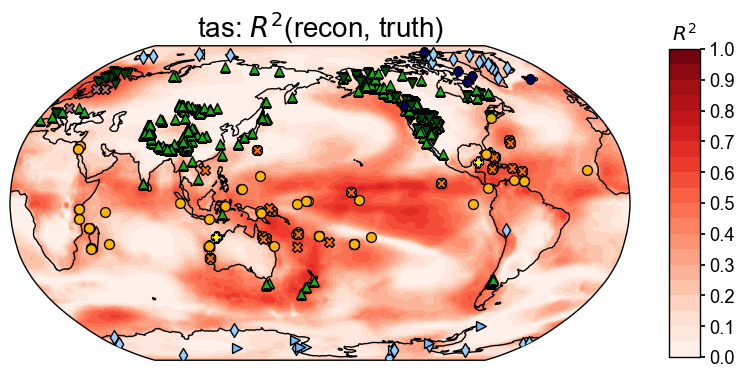

In [24]:
stat = 'R2'
valid_fd = res.recons['tas'].validate(
    job.obs['tas'].annualize(), stat=stat,
    valid_period=(1900, 2000),
    interp_direction='to-ref',
)
fig, ax = valid_fd.plot(
    title=fr'tas: $R^2$(recon, truth)',
    # projection='PlateCarree',
    # latlon_range=(-18, 18, 152, 248),
    add_cyclic_point=True,
    site_lats=lats, site_lons=lons,
    site_markersize=markersizes, site_marker=markers,
    site_color=colors, cbar_title_y=1,
    **valid_fd.plot_kwargs)

/Users/fengzhu/Apps/miniconda3/envs/cfr-env/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1700: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  result = super().scatter(*args, **kwargs)


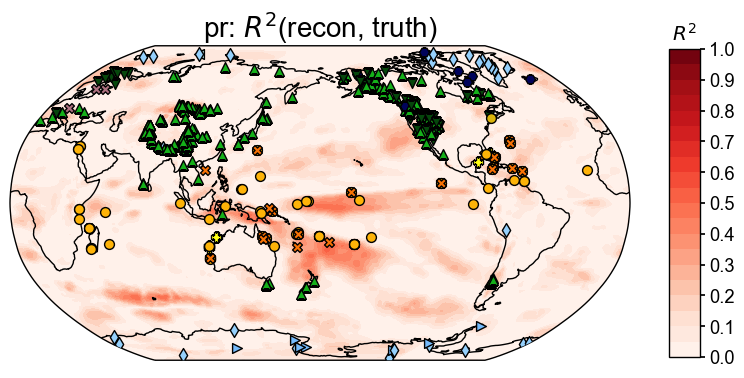

In [27]:
stat = 'R2'
valid_fd = res.recons['pr'].validate(
    job.obs['pr'].annualize(), stat=stat,
    valid_period=(1900, 2000),
    interp_direction='to-ref',
)
fig, ax = valid_fd.plot(
    title=fr'pr: $R^2$(recon, truth)',
    # projection='PlateCarree',
    # latlon_range=(-18, 18, 152, 248),
    add_cyclic_point=True,
    site_lats=lats, site_lons=lons,
    site_markersize=markersizes, site_marker=markers,
    site_color=colors, cbar_title_y=1,
    **valid_fd.plot_kwargs)